# Visualization 3

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import requests
import re

# new import statements
import geopandas as gpd
from shapely.geometry import Point, Polygon, box

In [2]:
# Find the path for "naturalearth_lowres"
path = gpd.datasets.get_path("naturalearth_lowres")
# Read the shapefile for "naturalearth_lowres" and
# set index using "name" column
gdf = gpd.read_file(path).set_index("name")

### Extracting "Europe" data from "naturalearth_lowres"

In [3]:
# Europe bounding box
eur_window = box(-10.67, 34.5, 31.55, 71.05)

Can we use `intersects` method?

In [4]:
gdf.intersects(eur_window)

name
Fiji                        False
Tanzania                    False
W. Sahara                   False
Canada                      False
United States of America    False
                            ...  
Serbia                       True
Montenegro                   True
Kosovo                       True
Trinidad and Tobago         False
S. Sudan                    False
Length: 177, dtype: bool

<AxesSubplot:>

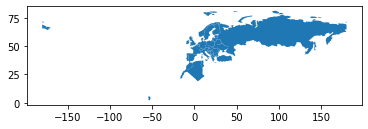

In [5]:
# Incorrect
gdf[gdf.intersects(eur_window)].plot()

Can we use `intersection` method?

In [6]:
gdf.intersection(eur_window)

name
Fiji                                                            POLYGON EMPTY
Tanzania                                                        POLYGON EMPTY
W. Sahara                                                       POLYGON EMPTY
Canada                                                          POLYGON EMPTY
United States of America                                        POLYGON EMPTY
                                                  ...                        
Serbia                      POLYGON ((18.82984 45.90888, 19.59604 46.17173...
Montenegro                  POLYGON ((19.80161 42.50009, 19.73805 42.68825...
Kosovo                      POLYGON ((20.52295 42.21787, 20.28375 42.32026...
Trinidad and Tobago                                             POLYGON EMPTY
S. Sudan                                                        POLYGON EMPTY
Length: 177, dtype: geometry

<AxesSubplot:>

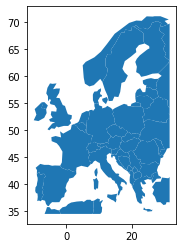

In [7]:
gdf.intersection(eur_window).plot()

How can we get rid of empty polygons?
- Sometimes empty polygons will mess up with your plot in case of specifying colors or other formatting

In [8]:
eur = gdf.intersection(eur_window)
eur.is_empty

name
Fiji                         True
Tanzania                     True
W. Sahara                    True
Canada                       True
United States of America     True
                            ...  
Serbia                      False
Montenegro                  False
Kosovo                      False
Trinidad and Tobago          True
S. Sudan                     True
Length: 177, dtype: bool

Remove all the empty polygons using `is_empty`.

In [9]:
eur = eur[~eur.is_empty]
eur

name
Russia              MULTIPOLYGON (((31.54002 52.74205, 31.30520 53...
Norway              POLYGON ((29.39955 69.15692, 28.59193 69.06478...
France              MULTIPOLYGON (((6.65823 49.20196, 8.09928 49.0...
Tunisia             POLYGON ((8.14098 34.65515, 8.37637 35.47988, ...
Algeria             POLYGON ((-1.79299 34.52792, -2.16991 35.16840...
Sweden              POLYGON ((11.46827 59.43239, 12.30037 60.11793...
Belarus             POLYGON ((29.22951 55.91834, 29.37157 55.67009...
Ukraine             POLYGON ((30.74875 46.58310, 30.37761 46.03241...
Poland              POLYGON ((23.52754 53.47012, 23.80493 53.08973...
Austria             POLYGON ((16.90375 47.71487, 16.34058 47.71290...
Hungary             POLYGON ((22.64082 48.15024, 22.71053 47.88219...
Moldova             POLYGON ((26.85782 48.36821, 27.52254 48.46712...
Romania             POLYGON ((28.67978 45.30403, 29.14972 45.46493...
Lithuania           POLYGON ((26.58828 55.16718, 25.76843 54.84696...
Latvia         

<AxesSubplot:>

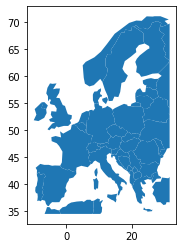

In [10]:
eur.plot()

### Centroids of European countries

/tmp/ipykernel_3158205/1089923979.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  eur.centroid.plot(ax=ax)


<AxesSubplot:>

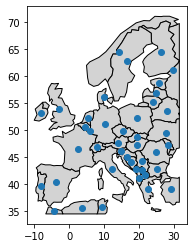

In [11]:
# plot the centroids
ax = eur.plot(facecolor="lightgray", edgecolor="k")
eur.centroid.plot(ax=ax)

### Lat / long CRS

- Long is x-coord
- Lat is y-coord
    - tells you where the point on Earth is
- **IMPORTANT**: degrees are not a unit of distance. 1 degree of longitute near the equator is a lot farther than moving 1 degree of longitute near the north pole

Using `.crs` to access CRS of a gdf.




In [12]:
eur.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Single meter-based CRS doesn't work for the whole earth

- Setting a different CRS for Europe that is based on meters.
- https://spatialreference.org/ref/?search=europe

In [13]:
# Setting CRS to "EPSG:3035" for European Union
eur_m = eur.to_crs("EPSG:3035")
eur_m.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

<AxesSubplot:>

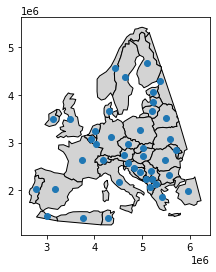

In [14]:
ax = eur_m.plot(facecolor="lightgray", edgecolor="k")
eur_m.centroid.plot(ax=ax)

#### How much error does lat/long computation introduce?

/tmp/ipykernel_3158205/3478192974.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  eur.centroid.to_crs("EPSG:3035").plot(ax=ax, color="r")  # red => miscalculated


<AxesSubplot:>

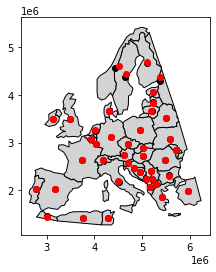

In [15]:
ax = eur_m.plot(facecolor="lightgray", edgecolor="k")
eur_m.centroid.plot(ax=ax, color="k") # black => correct
eur.centroid.to_crs("EPSG:3035").plot(ax=ax, color="r")  # red => miscalculated

### Areas of European countries

In [16]:
eur_m.area # area in sq meters

name
Russia              2.024604e+11
Norway              3.286343e+11
France              5.595585e+11
Tunisia             6.547702e+10
Algeria             2.043067e+11
Sweden              4.505641e+11
Belarus             2.039346e+11
Ukraine             2.857955e+11
Poland              3.103969e+11
Austria             8.506301e+10
Hungary             9.247413e+10
Moldova             3.232099e+10
Romania             2.383473e+11
Lithuania           6.382974e+10
Latvia              6.392371e+10
Estonia             4.467593e+10
Germany             3.574253e+11
Bulgaria            1.102150e+11
Greece              1.319524e+11
Turkey              2.217875e+11
Albania             2.969486e+10
Croatia             5.752945e+10
Switzerland         4.618538e+10
Luxembourg          2.416819e+09
Belgium             3.012566e+10
Netherlands         4.002133e+10
Portugal            9.340841e+10
Spain               5.023083e+11
Ireland             5.845217e+10
Italy               3.150991e+11
Denma

What is the area in **sq miles**?

In [17]:
# Conversion: / 1000 / 1000 / 2.59
(eur_m.area / 1000 / 1000 / 2.59).sort_values(ascending=False)
# careful!  some countries (e.g., Russia) were cropped when we did intersection

name
France              216045.735320
Spain               193941.416516
Sweden              173962.955903
Germany             138002.030052
Finland             131750.182704
Norway              126885.828356
Italy               121659.867544
Poland              119844.344075
Ukraine             110345.741832
United Kingdom       96519.589998
Romania              92025.972522
Turkey               85632.236650
Algeria              78882.882393
Belarus              78739.245551
Russia               78170.023756
Greece               50946.870966
Bulgaria             42554.046136
Portugal             36065.021674
Hungary              35704.295877
Austria              32842.862855
Czechia              31354.126319
Serbia               29493.813018
Tunisia              25280.702563
Latvia               24680.969176
Lithuania            24644.688797
Ireland              22568.405096
Croatia              22212.141886
Bosnia and Herz.     19538.365073
Slovakia             18172.796262
Switzerla

In [18]:
# area on screen, not real area
eur.area

/tmp/ipykernel_3158205/3689342177.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  eur.area


name
Russia              35.748174
Norway              61.455274
France              65.673811
Tunisia              6.540885
Algeria             21.165124
Sweden              79.446214
Belarus             27.622448
Ukraine             35.483088
Poland              40.759231
Austria             10.179604
Hungary             10.980058
Moldova              3.837658
Romania             27.621146
Lithuania            9.022101
Latvia               9.398691
Estonia              6.905922
Germany             45.923594
Bulgaria            12.119548
Greece              13.743985
Turkey              23.109344
Albania              3.185163
Croatia              6.570063
Switzerland          5.440201
Luxembourg           0.301516
Belgium              3.829997
Netherlands          5.264180
Portugal             9.802468
Spain               53.268425
Ireland              7.860299
Italy               34.685652
Denmark              6.168457
United Kingdom      34.202954
Slovenia             2.225310
Finla

## Madison area emergency services

- Data source: https://data-cityofmadison.opendata.arcgis.com/
    - Search for:
        - "City limit"
        - "Lakes and rivers"
        - "Fire stations"
        - "Police stations"

- CRS for Madison area: https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#/media/File:Universal_Transverse_Mercator_zones.svg

In [19]:
city = gpd.read_file("City_Limit.zip").to_crs("epsg:32616")
# 3rd digit (6 stands for north hemisphere, 7 stands for south)
# last two digits stand for the vertical mercator coordinate 

In [20]:
city.crs

<Derived Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
water = gpd.read_file("Lakes_and_Rivers.zip").to_crs(city.crs)
fire = gpd.read_file("Fire_Stations.zip").to_crs(city.crs)
police = gpd.read_file("Police_Stations.zip").to_crs(city.crs)

#### Run this on your virtual machine

`sudo sh -c "echo 'Options = UnsafeLegacyRenegotiation' >> /etc/ssl/openssl.cnf"`

then restart notebook!

#### GeoJSON

How to find the below URL?

- Go to info page of a dataset, for example: https://data-cityofmadison.opendata.arcgis.com/datasets/police-stations/explore?location=43.081769%2C-89.391550%2C12.81
- Then click on "I want to use this" > "View API Resources" > "GeoJSON"

In [22]:
url = "https://maps.cityofmadison.com/arcgis/rest/services/Public/OPEN_DATA/MapServer/2/query?outFields=*&where=1%3D1&f=geojson"
police2 = gpd.read_file(url).to_crs(city.crs)

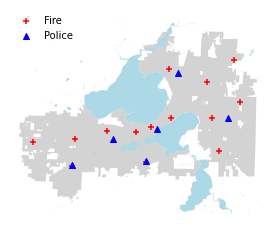

In [23]:
ax = city.plot(color="lightgray")
water.plot(color="lightblue", ax=ax)
fire.plot(color="red", ax=ax, marker="+", label="Fire")
police2.plot(color="blue", ax=ax, marker="^", label="Police")
ax.legend(loc="upper left", frameon=False)
ax.set_axis_off()

In [24]:
fire.to_file("fire.geojson")

### Geocoding: street address => lat / lon

- Daily incident reports: https://www.cityofmadison.com/fire/daily-reports

In [25]:
url = "https://www.cityofmadison.com/fire/daily-reports"
r = requests.get(url)
r

<Response [200]>

In [26]:
r.raise_for_status() # give me an exception if not 200 (e.g., 404)

In [27]:
# doesn't work
# pd.read_html(url)

In [28]:
# print(r.text)

Find all **span** tags with **streeAddress** using regex.

In [29]:
addrs = re.findall(r'<span itemprop="streetAddress">(.*?)</span>', r.text)[:-1]
addrs = pd.Series(addrs) + "; Madison, WI"
addrs

0        4200 block West Beltline Highway; Madison, WI
1                500 block Roman Mist Way; Madison, WI
2               I-90 Westbound (MM 141.4); Madison, WI
3              2000 block Northport Drive; Madison, WI
4                 2200 block Catalpa Road; Madison, WI
5                   6900 block Watts Road; Madison, WI
6           300 block N. Marquette Street; Madison, WI
7                  6600 block Sutton Road; Madison, WI
8    U.S. Highway 12 Westbound & Agriculture Drive;...
9                10 block S. Blair Street; Madison, WI
dtype: object

In [30]:
gpd.tools.geocode("4200 block West Beltline Highway; Madison, WI")

,geometry,address
0,POINT (-89.48520 43.05179),"West Beltline Highway, 53719, Madison, Wiscons..."


In [31]:
incidents = gpd.tools.geocode(addrs).dropna()
incidents

,geometry,address
0,POINT (-89.48520 43.05179),"West Beltline Highway, 53719, Madison, Wiscons..."
1,POINT (-89.54874 43.05300),"Roman Mist Way, 63719, Madison, Wisconsin, Uni..."
3,POINT (-89.36225 43.13029),"Northport Drive, 53704, Madison, Wisconsin, Un..."
4,POINT (-89.40273 43.04050),"Catalpa Road, 53713, Madison, Wisconsin, Unite..."
5,POINT (-89.54788 43.05074),"Watts Road, 63719, Madison, Wisconsin, United ..."
6,POINT (-89.34185 43.10418),"North Marquette Street, 53704, Madison, Wiscon..."
7,POINT (-89.49348 43.03998),"Sutton Road, 53711, Madison, Wisconsin, United..."
8,POINT (-89.29348 43.06091),"Agriculture Drive, 53718;53558, Madison, Wisco..."
9,POINT (-89.38160 43.07387),"10 East Doty at Block89, 10, East Doty Street,..."


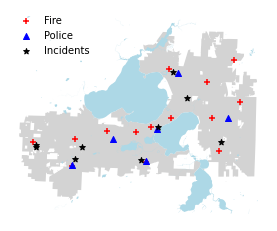

In [32]:
ax = city.plot(color="lightgray")
water.plot(color="lightblue", ax=ax)
fire.plot(color="red", ax=ax, marker="+", label="Fire")
police2.plot(color="blue", ax=ax, marker="^", label="Police")
incidents.to_crs(city.crs).plot(ax=ax, color="k", marker="*", label="Incidents")
ax.legend(loc="upper left", frameon=False)
ax.set_axis_off()